In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math
import scipy 
import scipy.integrate as si 
import scipy.interpolate 
import scipy.optimize
import seaborn as sns
import emcee
import corner
import getdist
import warnings
import re
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import DotProduct as DotP
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import uniform
from scipy.stats import norm
from getdist import plots, MCSamples

warnings.filterwarnings("ignore")

In [2]:
# Velocidade da luz em [km/s]
vel_c = 299792.4580 

# Temperatura da CMB em [K], erro de ± 0.002 ver Fixsen 2009 DOI:10.1088/0004-637X/707/2/916
T_0_cmb = 2.725

# Parâmetro de densidade da radiação eletromagnética x h2 ver eq. 8 https://arxiv.org/abs/1411.1074 
Omega_em_h2 = (4.482*10**(-7.0))*T_0_cmb**4.0 

# Número efetivo de neutrinos
Neff = 3.046

# Parâmetro de densidade total da radiação (E.M. + Neutrinos) x h2
Omega_r_h2 = Omega_em_h2*(1.0+0.2271*Neff)

# Parâmetro de densidade de matéria bariônica e o erro ± 0.0039
omega_b = 0.0493

# Parâmetro de densidade de matéria e o erro ± 0.0073
omega_m = 0.3153

# Razão entre massa do eletron e próton:
mu_0 = 1/1836.152

# erro em mu0
erro_mu_0 = 1.1e-6

# Lista com os valores fiduciais para os parâmetros de densidade do LambdaCDM (Ωb, Ωc, ΩΛ)
param_densidade = [0.049, 0.26, 0.69]

# Lista com valores para os cálculos segundo o modelo fiducial
param_cosmo = [0.3153, 0, 0.709, -1]

# H_{0} Planck
H0_PLANCK = 67.4

# Gamma 0, e o erro 0.07
gamma_0 = 0.79

# K o erro 0.12
K = 0.96 

## $D_{L}$  data:

In [3]:
# DL data
DL_DATA_PLANCK = pd.read_csv("DL_DATA_PLANCK.csv", index_col=None)
DL_PLANCK = DL_DATA_PLANCK['dL_Planck']
ERRO_DL_PLANCK = DL_DATA_PLANCK['erro_Planck']
redshift = DL_DATA_PLANCK['redshift']

## $f_{gas}$ data

In [4]:
# f_gas data
DADOS_FGAS = pd.read_csv("GMF.csv")
FGAS_OBS = DADOS_FGAS['Frac. Massa']
ERRO_FGAS_OBS = DADOS_FGAS['Erro']

# H(z)

In [5]:
def H_TH(omega_m, omega_k, h, w_x, z):
    Omega_tot = omega_m + omega_k + ( (Omega_r_h2)/(h**2.0) )
    if isinstance(z, (int, float)):
        Ez = (omega_m*(1+z)**3.0 + omega_k*(1+z)**2.0 + (Omega_r_h2/h**2)*(1+z)**4.0 \
              + (1.0-Omega_tot)*(1+z)**(3+3*w_x))**(1/2)
        return 100.0*h*Ez
    
    elif isinstance(z, np.ndarray):  
        Ez = (omega_m*(1+z)**3.0 + omega_k*(1+z)**2.0 + (Omega_r_h2/h**2)*(1+z)**4.0 \
              + (1.0-Omega_tot)*(1+z)**(3+3*w_x))**(1/2)
        return 100.0*h*Ez

In [6]:
H0_FID = H_TH(0.31, 0, .709, -1, 0)

In [7]:
H0_FID

70.89999999999999

# Cálculo do $d_{L}$ para o $\Lambda$-CDM

A seguir definimos a função que calcula o $d_{L}$ e usamos como input o $\Lambda$-CDM. Primeiro precisamos de uma função que faça o cálculo o $d_{C}$. Pois de:

$$
d_{L}(z) =(1+z) \frac{c}{H_{0}\sqrt{|\Omega_{k}|}}  \cdot f_k\left( \frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, d_{C}(z) \right)  \,\,\,\,\, ,
$$

sendo assim o $ f_{k} $ deve ser um de em três casos possíveis para determinados pela curvatura $k$: 

$$
f_{k} = \begin{cases}
    \begin{aligned}
        &\sin\left(\frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, d_{C}(z)\right), && \text{se }\Omega_{k} > 0, \\
        &d_{C}(z), && \text{se }\Omega_{k} = 0, \\
        &\sinh\left(\frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, d_{C}(z)\right), && \text{se }\Omega_{k} < 0.
    \end{aligned}
\end{cases}
$$

sendo $d_{C}$ ,

$$
d_{C} = c \int_{0}^{z}  \frac{dz^{\prime}}{H(z^{\prime})} \,\,\,\, .
$$   

In [8]:
def DL_TH(param_cosmo, z):

    omega_m, omega_k, h, w_x = param_cosmo

    def integrando(z_prime, omega_m, omega_k, h, w_x):
        return vel_c / H_TH(omega_m, omega_k, h, w_x, z_prime)
    
    dL_list = []
    for z in z:
        DC, erro_DC = si.quad(integrando, 0, z, args=(omega_m, omega_k, h, w_x))
        
        if omega_k < 0:
            dL = (1.0 + z) * (vel_c / (100.0 * h * np.sqrt(np.abs(omega_k)))) \
                 * np.sin((100.0 * h * np.sqrt(np.abs(omega_k)) / vel_c) * DC)
        elif omega_k > 0:
            dL = (1.0 + z) * (vel_c / (100.0 * h * np.sqrt(np.abs(omega_k)))) \
                 * np.sinh((100.0 * h * np.sqrt(np.abs(omega_k)) / vel_c) * DC)
        else:
            dL = (1.0 + z) * DC
        
        dL_list.append(dL)
    
    return np.array(dL_list)

In [9]:
def DA_FID(DL,z):
    return (DL/(1+z)**2)

In [10]:
param_cosmo = [0.3153, 0, 0.709, -1]

In [11]:
DL_FIDUCIAL = DL_TH(param_cosmo, redshift)
DA_FIDUCIAL = DA_FID(DL_FIDUCIAL, redshift)
DA_PLANCK = DA_FID(DL_PLANCK, redshift)

## A(z)

In [12]:
def A(dA_obs, dA_fid, H_obs, H_fid):
    theta = 0.442
    return ( (H_obs*dA_obs)/(H_fid*dA_fid) )**theta

In [13]:
A_PLANCK = A(DA_PLANCK, DA_FIDUCIAL, H0_PLANCK, H0_FID)

## $\gamma$(z)

In [14]:
def gamma_z(redshift):
    return gamma_0*(1 + 0.07*redshift)

In [15]:
gamma = gamma_z(redshift)

In [16]:
def FGAS_TH(dL_obs, dL_fid, A):
    omega_b = 0.0493
    omega_m = 0.3153
    
        
    return (  (  gamma*K*A*(omega_b/omega_m)*(  (dL_fid/dL_obs)**(3.0/2.0) ) ) )

In [17]:
FGAS_PLANCK = FGAS_TH(DL_PLANCK,DL_FIDUCIAL, A_PLANCK )

## $f_{gas}$ & $\mu$ relation


The gas mass $ M_{gas} (<R) $ within a radius $R$  obtained by X-ray observations can be written as [Sarazin 1988](https://ui.adsabs.harvard.edu/abs/1986RvMP...58....1S/abstract):

\begin{eqnarray}
M_{gas}\,  (<R) &=& \left( \frac{3 \pi \hbar m_e c^2}{2 (1+X) e^6}
\right)^{1/2}  \left( \frac{3 m_e c^2}{2 \pi k_B T_e} \right)^{1/4}
m_H \nonumber\\
& &\times \frac{1}{[\overline{g_B}(T_e)]^{1/2}}
{r_c}^{3/2} \left
[ \frac{I_M (R/r_c, \beta)}{I_L^{1/2} (R/r_c, \beta)} \right] [L_X
(<R)]^{1/2}\,\,\,\,\,\,\,\,\, (1)
\end{eqnarray}

where $X$ is the hydrogen mass fraction, $T_e$ is the gas temperature, $m_e$ and $m_H$ are the electron and hydrogen masses, respectively, $\overline{g_B}(T_e)$ is the Gaunt factor,  $r_c$ stands for the core radius and

$$
I_M (y, \beta) \equiv \int_0^y (1+x^2)^{-3 \beta/2} x^2 dx\;,
$$
$$
I_L (y, \beta) \equiv \int_0^y (1+x^2)^{-3 \beta} x^2 dx\;.
$$

From Eq.(1) and from $m_{H} = m_{p}(1+\mu)$, taking acount taht the bound energy of the sistem eletron-proton is $\sim 10^{4}$ smaller than the eletron rest mass and where $\mu = \frac{m_{e}}{m_{p}}$ is the electron to proton mass  ratio, so we can see that:

\begin{equation}
M_{gas} \, (<R) \propto \left(1+\mu\right).
\end{equation} 

On the other hand, the total mass  within a given radius $R$ can be obtained by assuming that the intracluster gas is in hydrostatic equilibrium, i.e.~[Allen 2008](https://doi.org/10.1111/j.1365-2966.2007.12610.x)
\begin{equation}
M_{tot} \,(<R) = - \left. \frac{k_B T_e R}{G \mu m_H} \frac{d \ln
n_e(r)}{d \ln r} \right|_{\, r=R}.
\end{equation}
Therefore, from we've seen for $m_{H}$ and applying to $M_{tot}$,

$$
f_{gas} \equiv \frac{\left(1+\mu\right)^{2}M_{gas}}{M_{tot}}.
$$

## Gerando os 40 valores de $\mu(z)$:

Assim, os dados de $\left( 1 + \mu \right)$ serão dados pela expressão:

$$
\left(1 + \mu \right)^{2} - \frac{ f_{gas}^{\, obs} }{f_{gas}^{\, th}}= 0
$$

In [18]:
GMF_PLANCK = FGAS_OBS/FGAS_PLANCK
MU_PLANCK = np.array(np.sqrt(np.abs(GMF_PLANCK)) - 1)

## Erros

O erro médio, $\sigma^{2}_{\text{tot}}$ é escrito como:  

$$
\sigma^{2}_{\text{tot}} =  \Sigma_{n} \, \left[ \frac{\partial \, G(X_{n})}{\partial X_{n}}\right]\sigma^{2}_{X_{n}}
$$

considerando que $G(X_{n})=  \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f} }$ temos:
$$ 
\sigma^{2}_{\text{tot} } = \left[ \frac{\partial}{\partial f^{ \text{obs}}_{\text{gás}} } \left(  \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{f^{\text{obs}}_{\text{gás}}} + \left[ \frac{\partial}{\partial \bar{f} } \left(  \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{\bar{f}}
$$

e assim,

$$ 
 \sigma^{2}_{\text{tot} } = \frac{1}{\bar{f}^{2} } \sigma^{2}_{f^{\text{obs}} } + \frac{f^{ \text{obs}^{2} } }{\bar{f}^{4} }\sigma^{2}_{\bar{f}}
$$


$$ 
 \sigma^{2}_{\text{tot} } =  \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left( \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} }  +  \frac{ \sigma^{2}_{\bar{f}}  }{\bar{f}^{2} } \right)
$$

finalmente $ \sigma^{2}_{\bar{f}}$ é dado do mesmo modo:

$$ 
\sigma^{2}_{\bar{f}} =  \Sigma_{m} \, \left[ \frac{\partial \, H(X_{m})}{\partial X_{m}}\right]\sigma^{2}_{X_{n}}
$$

e assim,

$$ 
\sigma^{2}_{\bar{f}} = \left[ \frac{\partial }{\partial K  } \bar{f} \right]^{2} \sigma^{2}_{K} +  \left[ \frac{\partial }{\partial A  } \bar{f} \right]^{2} \sigma^{2}_{A} +  \left[ \frac{\partial }{\partial \Omega_{b}   } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{b}} +  \left[ \frac{\partial }{\partial \Omega_{m}  } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{m}} +  \left[ \frac{\partial }{\partial d_{L}   } \bar{f} \right]^{2} \sigma^{2}_{d_{L} } 
$$


Portanto, o erro em relação à $\bar{f}$,


$$
\frac{\sigma^{2}_{ \bar{f} } }{\bar{f}^{2} } = \left[ \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{ \sigma^{2}_{A} }{A^{2}} \, + \,  \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \frac{ \sigma^{2}_{ \Omega_{m} } }{\Omega_{m}^{2}}  \, + \, \left(\frac{3}{2}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} }  \,   \right ]
$$

tomando o cuidado de lembrar que:


$$
 \sigma^{2}_{A}  =  \left( \frac{\partial A}{ \partial \theta } \right)^{2} \sigma^{2}_{\theta} 
$$

isto é,

$$
\sigma^{2}_{A} = \left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}
$$

Concluí-se que a expressão final para o erro médio, no primeiro modelo é:

$$
\sigma^{2}_{\text{tot} } = \frac{f^{ \text{obs}^{2} } }{{f}^{th\,\, 2} } \left[ \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} } \, + \, \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \, \frac{\left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}}{A^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{m} } }{\Omega_{m}^{2}}  \, + \, \left(\frac{3}{2}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} }  \,    \right ]
$$

In [19]:
sigma_K = 0.12
sigma_gamma = 0.11
sigma_omega_b = 0.0039
sigma_omega_m= 0.0073
sigma_theta = 0.035

In [20]:
def propagated_error_tot(f_obs, sigma_f_obs, f_th, sigma_K, K,
                         sigma_gamma, gamma, A, sigma_theta, 
                         sigma_omega_b, omega_b, sigma_omega_m, omega_m, 
                         sigma_d_L, d_L):

    
    term_1 = (sigma_f_obs ** 2) / (f_obs ** 2)
    term_2 = (sigma_K ** 2) / (K ** 2)
    term_3 = (sigma_gamma ** 2) / (gamma ** 2)
    term_4 = ((np.log(A) ** 2) * (sigma_theta ** 2)) / (A ** 2)
    term_5 = (sigma_omega_b ** 2) / (omega_b ** 2)
    term_6 = (sigma_omega_m ** 2) / (omega_m ** 2)
    term_7 = (3 / 2) ** 2 * (sigma_d_L ** 2) / (d_L ** 2)

    sigma_tot_squared = (f_obs ** 2 / f_th ** 2) * (term_1 + term_2 + term_3 + term_4 + term_5 + term_6 + term_7)

    return np.sqrt(sigma_tot_squared)

In [21]:
erro_mu_PLANCK = propagated_error_tot( FGAS_OBS, ERRO_FGAS_OBS, FGAS_PLANCK,
                                sigma_K, K, sigma_gamma, gamma, A_PLANCK, sigma_theta,
                                sigma_omega_b, omega_b, sigma_omega_m, omega_m, 
                                ERRO_DL_PLANCK, DL_PLANCK)

In [22]:
def delta_mu_with_error(muZ, errors):
    delta_mu = []
    delta_error = []
    
    for i in range(len(muZ) - 1):
        delta = muZ[i + 1] - muZ[i]
        
        delta_err = np.sqrt(errors[i + 1]**2 + errors[i]**2)
        
        delta_mu.append(delta)
        delta_error.append(delta_err)
    
    return np.array(delta_mu), np.array(delta_error)

In [23]:
Delta_MU_PLANCK, erro_delta_mu_PLANCK = delta_mu_with_error(MU_PLANCK, erro_mu_PLANCK)

In [24]:
print("Δμ(z) médio =", Delta_MU_PLANCK.mean())
print("Erros médio de Δμ(z) =", erro_mu_PLANCK.mean())

Δμ(z) médio = -0.006366790382630789
Erros médio de Δμ(z) = 0.27271808360032035


### The mean value of $\Delta \mu$ ( w/&nbsp; Planck data ):

$$
\Delta \mu_{PLANCK} = - 6.3 \cdot 10^{-3} \pm 2.7\cdot 10^{-1}
$$

In [25]:
data_mu_planck = {'redshift': redshift, 'mu':MU_PLANCK, 'mu_ERR':erro_mu_PLANCK}
mu0 = pd.Series({'redshift': 0, 'mu': 1/1837, 'mu_ERR':erro_mu_0 })

MU_DATA_PLANCK = pd.DataFrame(data_mu_planck)
MU_DATA_PLANCK = pd.concat([MU_DATA_PLANCK, pd.DataFrame([mu0])], ignore_index=True)

MU_DATA_PLANCK.to_csv("MU_DATA_PLANCK_ARTIGO-REVIEW.csv", index=False)

## GPR for $\mu(z)$

### load data

In [26]:
data = pd.read_csv("MU_DATA_PLANCK_ARTIGO-REVIEW.csv")
MU_PLANCK = data["mu"]
redshift = data["redshift"]
err_mu = data["mu_ERR"]

### plot data

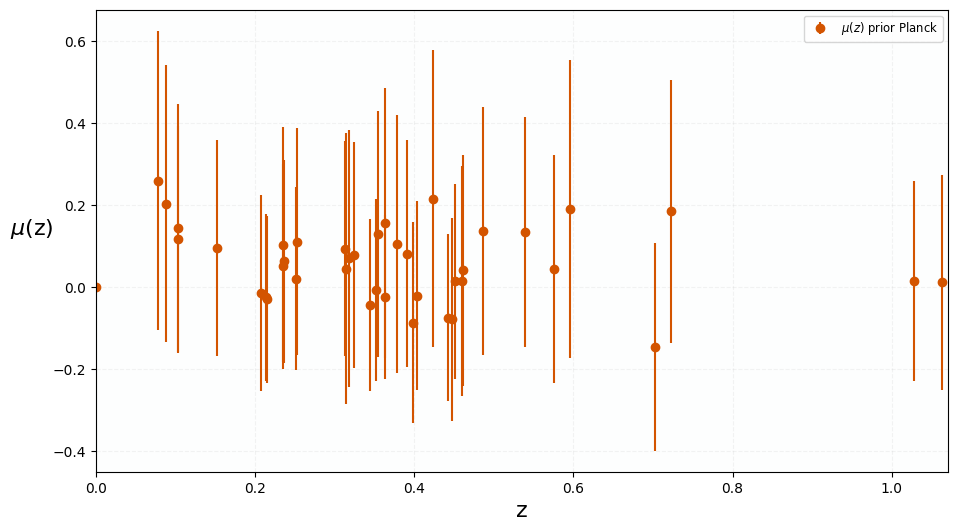

In [27]:
fig, ax = plt.subplots(figsize=(11, 6))
ax.errorbar(np.array(redshift), MU_PLANCK, yerr=err_mu, fmt="o", color="#D35400", 
            label=r'$\mu(z)$ prior Planck')
ax.grid(True, linestyle='--', alpha=0.15)
ax.set_facecolor('#FDFEFE')
ax.set_xlim(0.0, 1.071)
ax.set_xlabel('z', fontsize = '16')
ax.set_ylabel(r'$\mu$(z)', rotation=0, labelpad=15, fontsize='16')

legend_errorbar = ax.legend(loc='lower left', fontsize='small')
legend_hline = ax.legend(loc='upper right', fontsize='small')

### define variables

In [28]:
X = np.array(redshift).reshape(41,1)
Y = MU_PLANCK
X_star = np.linspace(0, 1.7, 41).reshape(41,1)

### optimize parameters (via random search)

In [29]:
def random_searchP(x, y, n): 
    best_score = -np.inf 
    best_params = None

    for _ in range(n):
        constant_value_1= np.random.uniform(1e-6, 1.5e-6)
        l = np.random.uniform(1, 4)

        kernel =C(constant_value=constant_value_1)*RBF(length_scale=l)
        model = GaussianProcessRegressor(kernel=kernel, alpha=41e-3)

        model.fit(x, y)

        score = model.score(x, y)

        if score > best_score:
            best_score = score
            best_params = { 'C1':constant_value_1, 'l':l}

    # mse
    y_pred = model.predict(x)
    mse = mean_squared_error(y, y_pred)
    
    print("Erro Quadrado Médio:", mse)                       
    return best_params, best_score


In [30]:
# define number of iterations
n_int = 250

In [31]:
best_params_PLANCK, best_score_PLANCK = random_searchP(X,Y, n_int)

Erro Quadrado Médio: 0.008314432115869413


In [32]:
print("Melhores parâmetros encontrados para PLANCK:\n")
for key, value in best_params_PLANCK.items():
    print(f"{key}: {value:.4f}")
print("")
print("Best score para PLANCK:\n")
print(f"{best_score_PLANCK:.4f}")

Melhores parâmetros encontrados para PLANCK:

C1: 0.0000
l: 1.0990

Best score para PLANCK:

-0.0378


In [33]:
constant1_PLANCK = best_params_PLANCK['C1']
l_PLANCK = best_params_PLANCK['l']

###  model fit

In [34]:
# define kernel
kernel_PLANCK =  C(constant_value=constant1_PLANCK)* RBF(length_scale=l_PLANCK)

In [35]:
# generate gaussian process regressor
muGPR_PLANCK = GaussianProcessRegressor(kernel=kernel_PLANCK, alpha=1e-4, normalize_y=True)

In [36]:
# model fit
muGPR_PLANCK.fit(X, Y)

GaussianProcessRegressor(alpha=0.0001,
                         kernel=0.00118**2 * RBF(length_scale=1.1),
                         normalize_y=True)

### model predict

In [37]:
Y_pred_PLANCK, std_PLANCK = muGPR_PLANCK.predict(X_star, return_std=True)

In [38]:
mu_pred_z_0 = Y_pred_PLANCK[0]
std_mu_pred_z_0 = std_PLANCK[0]

print("Valor previsto de mu para z=0:", mu_pred_z_0)
print("Erro associado ao valor previsto de mu para z=0:", std_mu_pred_z_0)

Valor previsto de mu para z=0: 0.0005500589483593554
Erro associado ao valor previsto de mu para z=0: 0.0008950460497906155


### plot results

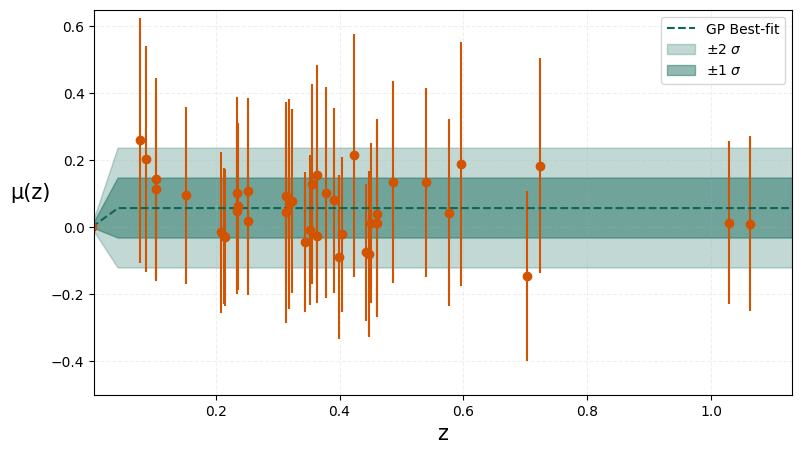

In [39]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.errorbar(np.array(redshift), MU_PLANCK, yerr=err_mu, fmt="o", color="#D35400")
plt.plot(X_star, Y_pred_PLANCK, color='#0E6655', linestyle='dashed',
         label='GP Best-fit')
ax.grid(True, linestyle='--', alpha=0.2)
plt.fill_between(X_star.flatten(), 
                 Y_pred_PLANCK - 2 * std_PLANCK, Y_pred_PLANCK + 2 * std_PLANCK, color='#0E6655', 
                 alpha=0.25, label=r'±2 $\sigma$')
plt.fill_between(X_star.flatten(), 
                Y_pred_PLANCK - std_PLANCK, Y_pred_PLANCK + std_PLANCK, color='#0E6655', 
              alpha=0.45, label=r'±1 $\sigma$')
plt.xlim(0.004, 1.13)
plt.ylim(-0.5, 0.65)


plt.xlabel('z', fontsize=15)
plt.ylabel('μ(z)', rotation=0, labelpad=15, fontsize=15)
plt.legend()
plt.savefig("gpr.png")
plt.show()

## MCMC for 2HDMLS parameters

In [40]:
z = np.linspace(0, 14, 1500).reshape(-1,1)

In [41]:
mu_GPR, std_mu_GPR = muGPR_PLANCK.predict(z, return_std=True)

In [42]:
Z_score = (np.abs(1/1837 - mu_GPR[0] ))/std_mu_GPR[0]
print("O valor de μ₀ calculado pelo GPR:",mu_GPR[0], "com erro:", std_mu_GPR[0],  
      "\n"+"está de acordo com a medida dentro de", round(Z_score,3), "σ")

O valor de μ₀ calculado pelo GPR: 0.0005500589483593554 com erro: 0.0008950460497906155 
está de acordo com a medida dentro de 0.006 σ


### yukawa coupling

$$
m_{e} = y_{e} \frac{v}{\sqrt{2}}
$$

$$
y_e = \frac{\sqrt{2} \times 0.511 \times 10^{-3} \, \text{GeV}}{246 \, \text{GeV}}
$$

usando $v = 246.22 \pm 0.02$ GeV e $ m_{e} = 0.5109989461 \pm 3.1\cdot 10^{-9}\,$ MeV 

$$
y_{e} \approx 2.9\cdot 10^{-3} \pm 2.4 \cdot 10^{-7}
$$

$$
\mu(z) - \frac{y_{e}}{\sqrt{2}}\frac{v_{2}}{m_{p}}cot\beta(z) = 0
$$

$$
v_2^{2} + v_{1}^{2} = v_{2}^{2}( 1 + cot\beta(z=0)^{2} ) = 246^{2} 
$$

$$
(1 + cot\beta^{2}) = \frac{246^{2}}{v_{2}^{2}}
$$

In [43]:
import emcee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

np.random.seed(42)
num_simulacoes = 55500

y_e = 0.0029
v2_std = 0.2 
cot_beta_std = 2e-2  
mp = 0.938 
mu0_PLANCK = mu_GPR[0] 

cotbeta0 = np.random.uniform(0, 1)
v20 = 246 / np.sqrt(1 + cotbeta0**2)

def objetivo(v2, cot_beta, mp, mu0):
    termo1 = mu0
    termo2 = (y_e * v2 * cot_beta) / (np.sqrt(2) * mp)
    return termo1 - termo2

tolerancia = 2e-2  

v2_samples = np.random.normal(v20, v2_std, num_simulacoes)
cot_beta_samples = np.random.normal(cotbeta0, cot_beta_std, num_simulacoes)

resultados = []
cadeias_amostras = []

for i in range(num_simulacoes):
    try:
        resultado = objetivo(v2_samples[i], cot_beta_samples[i], mp, mu0_PLANCK)
        
       
        v2_calculado = 246 / np.sqrt(1 + cot_beta_samples[i]**2)
        if np.abs(v2_samples[i] - v2_calculado) > tolerancia:
            continue  

        if isinstance(resultado, pd.Series):
            resultado = resultado.iloc[0]
        if np.isfinite(resultado):
            resultados.append(resultado)
            cadeias_amostras.append([v2_samples[i], cot_beta_samples[i]])
        else:
            resultados.append(np.inf)
    except Exception as e:
        print(f"Erro na simulação {i}: {e}")
        resultados.append(np.inf)

In [44]:
# Analisando os resultados do MCMC
resultados = np.array(resultados)
cadeias_amostras = np.array(cadeias_amostras)

In [45]:
melhor_indice = np.argmin(np.abs(resultados))
melhor_v2 = v2_samples[melhor_indice]
melhor_cot_beta = cot_beta_samples[melhor_indice]

erros = np.abs(resultados)

erros_v2 = np.abs(v2_samples - melhor_v2)
erros_cot_beta = np.abs(cot_beta_samples - melhor_cot_beta)

In [46]:
print("Melhores Parâmetros:\n")
print("v2:", melhor_v2)
print("cot_beta:", melhor_cot_beta)

print("\nErros Médios:\n")
print("Erro Médio para v2:", np.mean(erros_v2))
print("Erro Médio para cot_beta:", np.mean(erros_cot_beta))

Melhores Parâmetros:

v2: 230.61520390142135
cot_beta: 0.3480912221425625

Erros Médios:

Erro Médio para v2: 0.26466487734039307
Erro Médio para cot_beta: 0.028172827402673392


### plot results

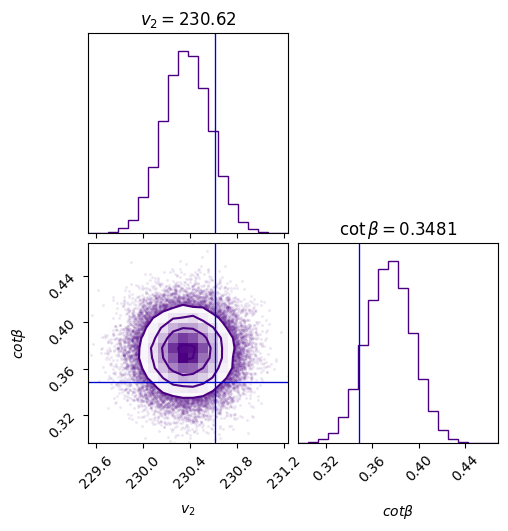

In [47]:
import corner

df = pd.DataFrame({'v1': v2_samples, 'tan_beta': cot_beta_samples})

figure = corner.corner(df, labels=[r'$v_{2}$', r'$cot\beta$'], hist_bin_factor=1, color='#4B0082')
axes = np.array(figure.axes).reshape((2, 2))

axes[0, 0].set_title(r'$v_{2} = $' + '{:.2f}'.format(melhor_v2))
axes[0, 0].axvline(x=melhor_v2, color='#0000CD', lw=0.96)
axes[1, 0].axvline(x=melhor_v2, color='#0000CD', lw=0.96)
axes[1, 0].axhline(y=melhor_cot_beta, color='#0000CD', lw=0.96)
axes[1, 1].set_title(r'$\cot\beta = $' + '{:.4f}'.format(melhor_cot_beta))
axes[1, 1].axvline(x=melhor_cot_beta, color='#0000CD', lw=0.96)
plt.savefig("maginal-plot.png")
plt.show()